In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 梯度消失或梯度爆炸

In [2]:
# Sigmoid激活函数
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


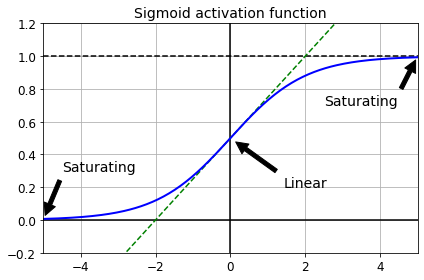

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier 和 He 权重初始化方法

In [4]:
# 先看看目前keras中支持的所有的初始化方法
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
# 使用特定初始化方法的示例，使用kernel_initializer参数
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
# 对初始化方法进行一些自定义
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 非饱和激活函数

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


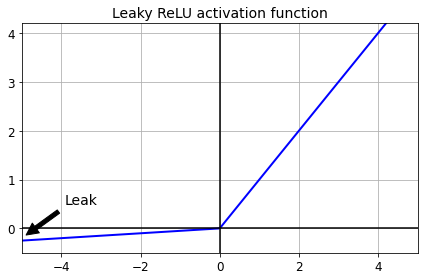

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
# 看看现在keras中能用的所有激活函数
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
# 有些激活函数需要特定的层对象
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Leaky ReLU激活函数使用实例

In [11]:
# 还是使用fashion_mnist数据集
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    # 若想要使用Leaky ReLU激活函数，就需要将LeakyReLU层添加到想要应用的层后面，如下
    keras.layers.Dense(300, kernel_initializer="he_normal"), # 要应用Leaky ReLU的层
    keras.layers.LeakyReLU(), # 添加到目标应用层的后面
    
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

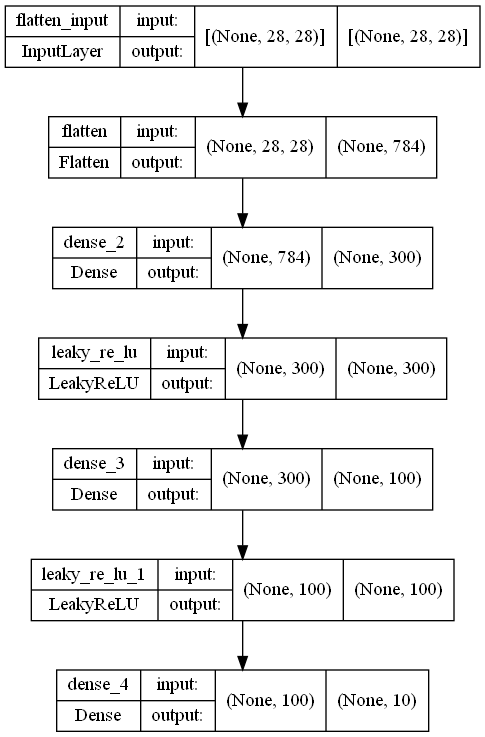

In [13]:
keras.utils.plot_model(model, "使用Leaky ReLU实例.png", show_shapes=True)

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7892
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6217 - accuracy: 0.7943 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5832 - accuracy: 0.8076 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accuracy:

非常滴棒棒，接下来再试试PReLU激活函数

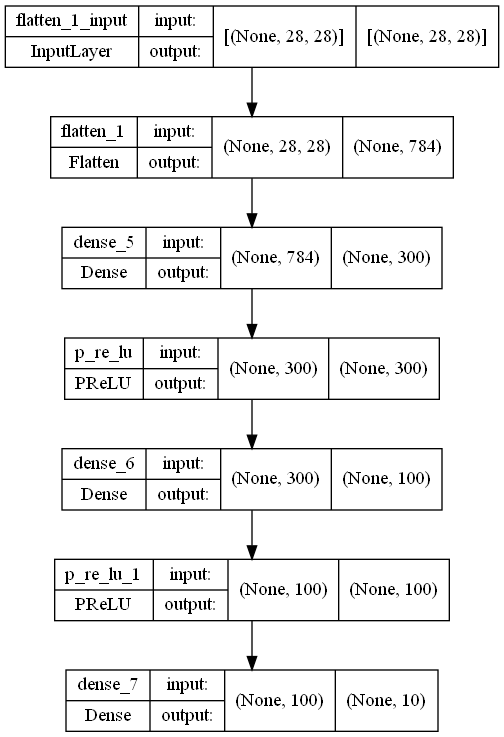

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    # 和Leaky ReLU激活函数的使用方法差不多嗷，也是在目标应用层下面创建PReLU层
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

keras.utils.plot_model(model, "使用PReLU实例.png", show_shapes=True)

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3461 - accuracy: 0.6208 - val_loss: 0.9254 - val_accuracy: 0.7184
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8196 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6965 - accuracy: 0.7694 - val_loss: 0.6564 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8052
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5390 - accuracy: 0.8207 - val_loss: 0.5196 - val_accuracy:

### ELU 激活函数

In [17]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


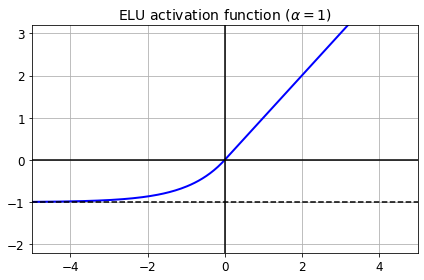

In [18]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [19]:
keras.layers.Dense(10, activation="elu")

### SELU 激活函数

ELU函数的衍生体(可扩展ELU)，效果据说很好，但是对于使用的限制很多，使用时要注意  
比如输入的数据必须是标准化的，即均值为0，标准差为1

In [20]:
from scipy.special import erfc

# alpha 和 scale 自归一化， 均值为0，标准差为1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [21]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


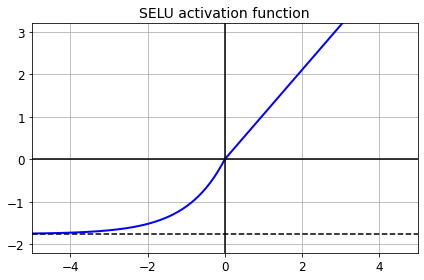

In [22]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

SELU激活函数的超参数(`scale` and `alpha`)是在保证这个前提下得到的，即：  
每个神经元和每层神经元的输出均值都在0左右，标准差都在1左右，即使有一千层神经网络，也不会改变这一特性；  
有效避免的梯度爆炸或梯度消失

In [23]:
# 模拟一下一千层神经网络下的使用SELU激活函数的各层的输出值的均值和标准差
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 模拟的标准化的输入值
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 初始化方法，假设这是某层各神经元权重
    Z = selu(np.dot(Z, W)) # 各神经元权重与输入值的点乘就是下一层神经元输入值的输出值之和
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [24]:
# 使用selu激活函数的方法很简单
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

## 批量归一化

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    # 使用方法很简单，只需要在要应用的层前实例化BatchNormalization对象就行
    # 虽说放在应用层之后也行，但是建议放在之前
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

看看加入批量归一化的情况吧，可看到神经网络中的归一化层的参数是前一层的4倍  
这是因为批量归一化总共有4个参数用以实现归一化

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_10 (Dense)            (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

如下是BatchNormalization层在网络中的4个参数的情况  
可看见其中有2个参数是不可训练的，这两个参数是由完整训练集的数据决定的，所以不受反向传播的影响

In [27]:
# 第二层神经元，即批量归一化层
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8293 - accuracy: 0.7219 - val_loss: 0.5539 - val_accuracy: 0.8154
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5704 - accuracy: 0.8034 - val_loss: 0.4793 - val_accuracy: 0.8374
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5161 - accuracy: 0.8214 - val_loss: 0.4424 - val_accuracy: 0.8494
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4788 - accuracy: 0.8315 - val_loss: 0.4212 - val_accuracy: 0.8558
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4548 - accuracy: 0.8406 - val_loss: 0.4050 - val_accuracy: 0.8614
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4385 - accuracy: 0.8444 - val_loss: 0.3932 - val_accuracy: 0.8624
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4254 - accuracy: 0.8504 - val_loss: 0.3830 - val_accuracy:

建议使用 `BatchNormalization` 层的时候，隐含层不要有偏置项，因为 `BatchNormalization` 层本身就会提供一个偏置项  
在定义神经元层的时候通过传递`use_bias=False` 参数就可以不要偏置项

In [29]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0346 - accuracy: 0.6739 - val_loss: 0.6679 - val_accuracy: 0.7882
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6757 - accuracy: 0.7819 - val_loss: 0.5537 - val_accuracy: 0.8208
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5962 - accuracy: 0.8021 - val_loss: 0.4996 - val_accuracy: 0.8350
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5456 - accuracy: 0.8176 - val_loss: 0.4655 - val_accuracy: 0.8462
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5140 - accuracy: 0.8249 - val_loss: 0.4419 - val_accuracy: 0.8512
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4916 - accuracy: 0.8310 - val_loss: 0.4237 - val_accuracy: 0.8532
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4742 - accuracy: 0.8376 - val_loss: 0.4102 - val_accuracy:

通常来说，实例化 `BatchNormalization` 层的时候只要保持默认参数配置就好，但是也有可能遇到需要调整的情况  
比如参数——动量 `momentum` 。动量的值最好接近于1，在数据集较大时，可设置为0.9；在数据集较小时，可尝试设置0.9999999

### 梯度裁剪

通过限制梯度值的方法来避免梯度爆炸的问题  
在优化器中可以设置 `clipnorm` 或 `clipvalue` 参数来分别达到使用l2范数或自定义值来裁剪梯度  
这个做法就有点像正则化

In [31]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [32]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# 重用预训练层

## 重用Keras模型

接下来要使用fashion MNIST数据集  
要将训练集分成两部分：  
* `X_train_A`: 较大的数据集。所有除了凉鞋和衬衫 (classes 5 and 6)的其他所有的8个类别.
* `X_train_B`: 较小的数据集。仅包含200个凉鞋和衬衫的图像.

验证集和测试集也这么划分，但是不限制图像的数量

首先将会使用数据集A训练出一个模型，然后尝试重用这个模型来处理数据集B(二元分类)。  
希望模型从任务A中学到的一些知识能应用到任务B中取，因为A任务的类别划分（运动鞋、踝靴、外套、t恤等）与B任务的类别（凉鞋和衬衫）有些相似。  
然而，由于使用的是`Dense`层，所以模型其实只有在模式一致的场景才能重用  
相比之下，迁移学习在卷积神经网络中的表现会更好，将在第14章中看到这一点

In [33]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # 凉鞋或是衬衫
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # 7, 8, 9 类别序号将变成 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # 二元分类: 当前输入是否是衬衫 (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [34]:
X_train_A.shape

(43986, 28, 28)

In [35]:
X_train_B.shape

(200, 28, 28)

In [36]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [37]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

先整一个任务A的模型

In [39]:
# 先整一个任务A的模型
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [40]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.5926 - accuracy: 0.8105 - val_loss: 0.3892 - val_accuracy: 0.8675
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3287 - val_accuracy: 0.8829
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3012 - val_accuracy: 0.8991
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2892 - val_accuracy: 0.9023
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2835 - accuracy: 0.9019 - val_loss: 0.2775 - val_accuracy: 0.9063
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2729 - accuracy: 0.9063 - val_loss: 0.2734 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2641 - accuracy: 0.9093 - val_loss: 0.2718 - val_accuracy:

In [41]:
model_A.save("my_model_A.h5")

再整一个独立的任务B的模型做个对照组，看看复用模型A是否有效果

In [42]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [43]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 24ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6311 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 11ms/step - loss: 0.5692 - accuracy: 0.7500 - val_loss: 0.4784 - val_accuracy: 0.8540
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3434 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9310
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3020 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 11ms/step - loss: 0.2801 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [44]:
model_B.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_22 (Dense)            (None, 300)               235500    
                                                                 
 dense_23 (Dense)            (None, 100)               30100     
                                                                 
 dense_24 (Dense)            (None, 50)                5050      
                                                                 
 dense_25 (Dense)            (None, 50)                2550      
                                                                 
 dense_26 (Dense)            (None, 50)                2550      
                                                                 
 dense_27 (Dense)            (None, 1)                

现在在模型A的基础上做迁移学习适配任务B  

* 注意，当前`model_B_on_A` 和 `model_A` 共享一些相同的层，若对`model_B_on_A` 进行训练，则会同时改变两个模型的权重。要避免这种情况，就需要在迁移学习设置的时候对`model_A` 使用*clone_model*进行深度复制

In [45]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
# 除了model_A_clone的输出层之外的层全都要
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [46]:
# 在编译之前需要将每层都设置为不可训练，这样这些层就不会受反向传播的影响而改变权重了
# 在训练的一开始由于model_B_on_A的输出层权重是随机的，所以一开始的梯度下降肯定是非常大的，这有可能会使其他层的权重发生过大的变化
# 所以就先保持其它层权重不变的情况下先训练几个轮次让输出层权重调整到适当位置，然后再将其他层设置回可训练
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [47]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# 现在输出层权重应该调整的比一开始好多了，再将所有层设置回可训练，以便反向传播
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

# 在此时，建议将学习率调小，以免对权重进行太大的改变——那样就丧失了迁移学习的目的了
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-4),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 24ms/step - loss: 0.5771 - accuracy: 0.6550 - val_loss: 0.5818 - val_accuracy: 0.6359
Epoch 2/4
7/7 [==============================] - 0s 11ms/step - loss: 0.5407 - accuracy: 0.6850 - val_loss: 0.5444 - val_accuracy: 0.6795
Epoch 3/4
7/7 [==============================] - 0s 11ms/step - loss: 0.5039 - accuracy: 0.7300 - val_loss: 0.5124 - val_accuracy: 0.7150
Epoch 4/4
7/7 [==============================] - 0s 11ms/step - loss: 0.4725 - accuracy: 0.7500 - val_loss: 0.4838 - val_accuracy: 0.7333
Epoch 1/16
7/7 [==============================] - 0s 24ms/step - loss: 0.4477 - accuracy: 0.7800 - val_loss: 0.4660 - val_accuracy: 0.7505
Epoch 2/16
7/7 [==============================] - 0s 11ms/step - loss: 0.4297 - accuracy: 0.8100 - val_loss: 0.4475 - val_accuracy: 0.7657
Epoch 3/16
7/7 [==============================] - 0s 11ms/step - loss: 0.4110 - accuracy: 0.8200 - val_loss: 0.4308 - val_accuracy: 0.7809
Epoch 4/16
7/7 [===============

看看迁移学习的效果

In [48]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1409 - accuracy: 0.9705


[0.14087332785129547, 0.9704999923706055]

In [49]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.2890 - accuracy: 0.9085


[0.288975328207016, 0.9085000157356262]

可见，迁移学习对于密集层组成的神经网络效果不是很好

# 更快的优化器

## 动量优化

In [50]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## Nesterov 动量加速梯度

In [51]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

自适应。优点是早期梯度下降很快，但是缺点是后期学习率缩小的速度太快，导致经常在到达全局最优解前就停止了  
但是在简单的如线性回归的任务中变现一直不错  
在各变量数值差别较大的应用中有较好的表现，此时损失函数是个拉长的碗状

In [52]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001) # 初始学习率

## RMSProp

自适应。AdaGrad的改进型，引入了指数衰减（就像动量优化那样，只不过参数名变为了rho）  
但是有时对于简单的问题，有时并没有AdaGrad更好

In [53]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9) # 初始学习率

## Adam

自适应矩估计。结合了像动量优化和RMSprop的优点，所以有两个超参数

In [54]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax

自适应。Adam的改进型。  
若将Adam稍加改造，可看成是Adam按照梯度的l2范数来缩放学习率  
Adamax按照这个思路，将l2范数换成了l∞范数来缩放学习率  
在某些数据集上，会比Adam更稳定

In [55]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam

自适应。相当于在Adam优化中使用Nesterov技巧  
通常来说总是比Adam要好，但是有时却不如RMSprop

In [56]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## 学习率调度

### 幂调度

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [57]:
# 每步计算，学习率都会变化
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [58]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [59]:
n_epochs = 25
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5955 - accuracy: 0.7946 - val_loss: 0.4741 - val_accuracy: 0.8358
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4528 - accuracy: 0.8393 - val_loss: 0.4187 - val_accuracy: 0.8570
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4222 - accuracy: 0.8505 - val_loss: 0.4656 - val_accuracy: 0.8254
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4041 - accuracy: 0.8581 - val_loss: 0.3973 - val_accuracy: 0.8600
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3927 - accuracy: 0.8619 - val_loss: 0.3866 - val_accuracy: 0.8646
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3813 - accuracy: 0.8651 - val_loss: 0.3803 - val_accuracy: 0.8702
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3741 - accuracy: 0.8675 - val_loss: 0.3753 - val_accuracy:

学习率的幂调度差不多就是这样的

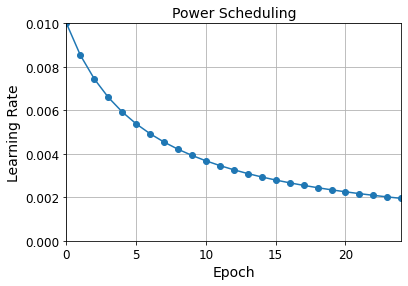

In [60]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 指数调度

```lr = lr0 * 0.1**(epoch / s)```

In [61]:
# 可以使用回调函数来实现指数调度，每个轮次结束后就会更新学习率
# 回调函数默认接受的第一个参数，是当前轮次的编号
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [62]:
# 但是如果想要更灵活地设置lr0和s，可以这么写
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [63]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [64]:
# 在自定义回调函数后，要将其传递给keras.callbacks.LearningRateScheduler后才能获得可用于fit方法的回调函数
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7311 - accuracy: 0.7621 - val_loss: 0.8696 - val_accuracy: 0.7486 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5019 - accuracy: 0.8285 - val_loss: 0.4155 - val_accuracy: 0.8526 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4435 - accuracy: 0.8486 - val_loss: 0.6018 - val_accuracy: 0.8018 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4021 - accuracy: 0.8631 - val_loss: 0.4183 - val_accuracy: 0.8690 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3769 - accuracy: 0.8710 - val_loss: 0.3737 - val_accuracy: 0.8768 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3497 - accuracy: 0.8804 - val_loss: 0.4123 - val_accuracy: 0.8724 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 5s

In [65]:
# 回调函数除了能传递当前轮次编号以外，默认第二个参数就是当前学习率
# 于是指数调度的回调函数可以这么写
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

在保存模型的时候，会将模型的优化器和学习率保存下来，所以如果像上面这样写回调函数的话，就可以暂停模型的训练后保存然后之后再导入模型，就可以在中断的地方继续训练  
但是如果回调函数中用到了`epoch`就不行了，因为模型的保存不会保存当前的轮次，如果导入模型训练的话，`epoch`就会被重置为0，但是也不是没有解决办法，那就是可以在`fit()`方法中设置`initial_epoch`

每个轮次变一次学习率就像这样

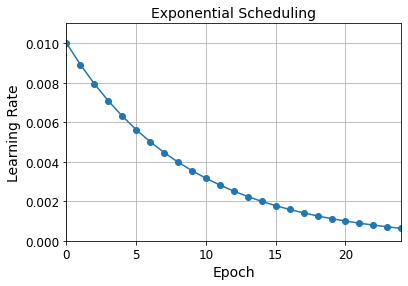

In [66]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [67]:
# 如果想要在每个步骤都改变学习率的话，可以自定义一个回调函数
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 在每个轮次结束之后，batch都会重置
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [68]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20个轮次中计算步骤的个数 (fit方法默认batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7079 - accuracy: 0.7667 - val_loss: 0.7483 - val_accuracy: 0.7694 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5177 - accuracy: 0.8252 - val_loss: 0.4501 - val_accuracy: 0.8532 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4464 - accuracy: 0.8485 - val_loss: 0.7346 - val_accuracy: 0.7968 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4052 - accuracy: 0.8607 - val_loss: 0.4138 - val_accuracy: 0.8682 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3745 - accuracy: 0.8712 - val_loss: 0.3713 - val_accuracy: 0.8748 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3488 - accuracy: 0.8797 - val_loss: 0.3657 - val_accuracy: 0.8808 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

In [69]:
# 但是，也可以使用keras自带的Learning rate schedules API 来实现每个步骤都改变学习率
s = 20 * len(X_train) // 32 # 20个轮次中计算步骤的个数 (fit方法默认batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = s, decay_rate = 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1332 - accuracy: 0.9512 - val_loss: 0.4063 - val_accuracy: 0.8984
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1306 - accuracy: 0.9521 - val_loss: 0.4120 - val_accuracy: 0.8988
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1292 - accuracy: 0.9531 - val_loss: 0.4117 - val_accuracy: 0.8970
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1282 - accuracy: 0.9531 - val_loss: 0.4089 - val_accuracy: 0.8990
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1276 - accuracy: 0.9531 - val_loss: 0.4085 - val_accuracy: 0.8982
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1268 - accuracy: 0.9534 - val_loss: 0.4124 - val_accuracy: 0.8996
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1261 - accuracy: 0.9537 - val_loss: 0.4153 - val_accuracy:

每个计算步骤变一次学习率就像这样

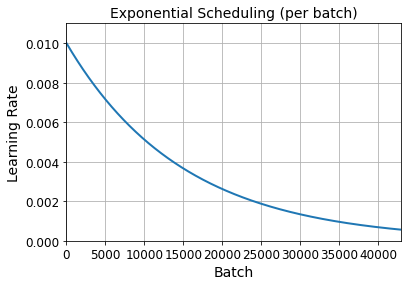

In [70]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 分段常数调度

分段常数调度依然依靠回调函数来实现

In [71]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [72]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [73]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7282 - accuracy: 0.7619 - val_loss: 0.9417 - val_accuracy: 0.7176 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5489 - accuracy: 0.8168 - val_loss: 0.4974 - val_accuracy: 0.8442 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5024 - accuracy: 0.8347 - val_loss: 0.8108 - val_accuracy: 0.7704 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4706 - accuracy: 0.8458 - val_loss: 0.4477 - val_accuracy: 0.8526 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4594 - accuracy: 0.8527 - val_loss: 0.4984 - val_accuracy: 0.8422 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3469 - accuracy: 0.8798 - val_loss: 0.3983 - val_accuracy: 0.8736 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 5s

分段常数调度非常好理解，就像这样

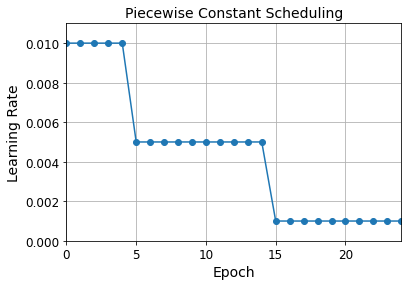

In [74]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 性能调度

性能调度和其他的调度都不太一样  
它会在每N步就验证一下误差，当误差停止下降时，就将学习率降低$\lambda$倍，就行提前停止一样  
使用keras自带的回调函数就可以实现

In [75]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5510 - accuracy: 0.8032 - val_loss: 0.4726 - val_accuracy: 0.8366 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4376 - accuracy: 0.8423 - val_loss: 0.4410 - val_accuracy: 0.8430 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4143 - accuracy: 0.8504 - val_loss: 0.3729 - val_accuracy: 0.8648 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3949 - accuracy: 0.8579 - val_loss: 0.3914 - val_accuracy: 0.8668 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3792 - accuracy: 0.8633 - val_loss: 0.3542 - val_accuracy: 0.8684 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3685 - accuracy: 0.8671 - val_loss: 0.3915 - val_accuracy: 0.8714 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 3s

可以看一下性能调度和分段常数调度的曲线比较

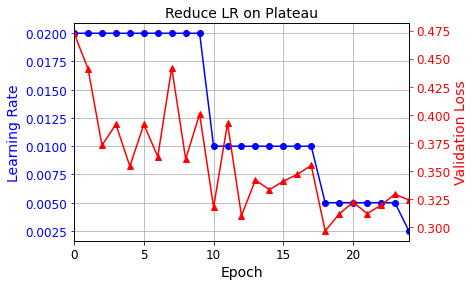

In [76]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

这个很有用，可以使用它的自带的一些调度方法的实现  
来实现对学习率进行基于计算步数，而不是轮次的调度  
在不久前的指数调度的例子中就说过这个

In [77]:
# 比如还可以来实现基于计算步数的分段常数调度
# 之前的例子是基于计算轮次的调度
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

一周期调度  
这是一个由经验得到的方法：从较小的学习率开始，随着计算步数的增长再增大学习率至最大学习率，然后再减小  
首先确定一个最优的学习率（一个大致的值就行了），然后一般将最大学习率除10得到初始学习率，之后随着步数改变学习率  
好处是可以提高模型训练的速度，减少必要的轮次数

In [78]:
'''
首先来确定最大的学习率

使用指数调度来大致估计一下最大学习率是多少，用很多的指数变化的学习率分别都用同一个模型的唯一一个轮次的不同batch训练一哈
画出个所有batch的loss vs. rate图，看看rate大概在什么位置
'''
K = keras.backend

# 指数调度回调函数
class ExponentialLearningRate(keras.callbacks.Callback):
    """
    之所以要使用回调函数来实现指数调度，就是因为方便在每次batch的训练后输出loss和rate
    """
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    """
    这里有一个重要的细节。
    目标是仅在一个轮次内，查看不同的学习率对不同的batch数据的loss
    那么在这个轮次结束后，就必然要还原模型的初始配置，以便使用1Cycle scheduling
    """
    # 先保存初始设置，在训练完之后要还原初始设置
    init_weights = model.get_weights()
    init_lr = K.get_value(model.optimizer.learning_rate)
    iterations = math.ceil(len(X) / batch_size) * epochs
    # 首先让学习率从最小值算
    K.set_value(model.optimizer.learning_rate, min_rate)
    # 每个batch完成训练后的学习率变化参数
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    # 还原初始配置
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [79]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

通过下面的图可看出，最大学习率差不多可以选0.05

430/430 [==============================] - 1s 2ms/step - loss: 74025460413909141974679552.0000 - accuracy: 0.3023


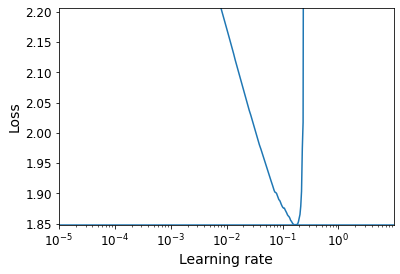

In [80]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [81]:
# 定义1周期调度的回调函数
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [82]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.8999 - accuracy: 0.7112 - val_loss: 0.6159 - val_accuracy: 0.7996
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.5613 - accuracy: 0.8109 - val_loss: 0.5027 - val_accuracy: 0.8322
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4921 - accuracy: 0.8274 - val_loss: 0.4847 - val_accuracy: 0.8254
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4596 - accuracy: 0.8369 - val_loss: 0.4552 - val_accuracy: 0.8406
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4451 - accuracy: 0.8424 - val_loss: 0.4343 - val_accuracy: 0.8490
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4291 - accuracy: 0.8462 - val_loss: 0.4139 - val_accuracy: 0.8598
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4163 - accuracy: 0.8519 - val_loss: 0.4062 - val_accuracy: 0.8596
Epoch 

# 使用正则化来避免过拟合

## $\ell_1$ and $\ell_2$ regularization

In [101]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [84]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 1.5581 - accuracy: 0.7762 - val_loss: 1.0216 - val_accuracy: 0.7614
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9082 - accuracy: 0.7935 - val_loss: 0.8502 - val_accuracy: 0.8178


In [85]:
# 使用Python自带的partial可以让代码更简单
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 1.5975 - accuracy: 0.7781 - val_loss: 1.0108 - val_accuracy: 0.7664
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9066 - accuracy: 0.7955 - val_loss: 0.8515 - val_accuracy: 0.8190


## Dropout

<b><font size=5 color=red face="华文彩云">注意</font></b>  
加入dropout层之后，其只会在训练的时候被激活  
这也就是说在训练时计算的训练集的loss是不符合实际，有可能会出现虽然训练集和验证集的差距不大，但还是过拟合的现象。就像使用了如批量归一化算法一样的情况。  
如果像了解真实的训练集的loss，只能在训练结束后重新计算训练集的Loss或准确率

In [87]:
model = keras.models.Sequential([
    # 可以看到，Dropout需要添加到目标层之后
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5792 - accuracy: 0.7885 - val_loss: 0.4288 - val_accuracy: 0.8432
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4539 - accuracy: 0.8333 - val_loss: 0.3724 - val_accuracy: 0.8614


## Alpha Dropout

如果当前网络的激活函数式SELU激活函数，那么dropout就会破坏归一化  
就需要使用alpha dropout，其会保持输入的均值和标准差不变

In [91]:
model = keras.models.Sequential([
    
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1834/1834 [==============================] - 4s 2ms/step - loss: 1.0615 - accuracy: 0.5985 - val_loss: 0.9850 - val_accuracy: 0.6930
Epoch 2/2
1834/1834 [==============================] - 4s 2ms/step - loss: 0.9210 - accuracy: 0.6522 - val_loss: 1.0451 - val_accuracy: 0.6966


In [92]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.0985 - accuracy: 0.6755


[1.0985455513000488, 0.6754999756813049]

## 蒙特卡罗(MC) Dropout

实现MC Dropout的重要操作就是将training设置为True  
然后就可以不停的边训练边预测地循环一个数据集很多次，然后求出平均值作为最终的预测值  
是的，就像个集成模型一样  
  
<b><font color=red>注意:</font></b>  原本是用于提高dropout网络（即在每个权重层后面都有一个dropout层的神经网络）模型性能的方法

In [96]:
# 强制刚才的带alpha dropout的网络使用测试集训练100次并输出每次预测结果，相当于有100个不同的应用了dropout模型在训练的过程中输出的结果(此时dropout已被激活)
# 因为测试集的形状是[10000, 10]，输出的y_probas形状应该是[100, 10000, 10]
# 之所以要调用model的call()方法来实现，是因为只有call()才有
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
# 所有模型的预测结果平均值，整的有点像集成模型
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [95]:
y_proba.shape

(10000, 10)

In [97]:
# 当然也不用非要像上面那样使用call()方法强制使模型在预测的时候也激活dropout，也可以像下面这样使用predict()方法
# 首先要继承Dropout或AlphaDropout类改造一下，将training恒设为True。其中当原始模型中使用了如批量归一化的特殊层时那就不得不继承AlphaDropout类了
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [98]:
# 基于旧的alpha dropout模型重新整一个模型，只把alpha dropout层换成自定义的MCAlphaDropout层就行，其他的参数如学习率和权重都不需要变
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [99]:
# 可看见原始的模型中的alpha dropout模型中的AlphaDropout层都被替换成了MCAlphaDropout层
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_65 (Dense)            (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_66 (Dense)            (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [100]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# 编译完了之后记得把旧模型的权重拿过来
mc_model.set_weights(model.get_weights())

现在就可以使用MC Dropout了，下面以测试集第一个样本(第一张图片，[1, 28, 28])为例输出MC Dropout模型的结果

In [103]:
np.round(np.mean([mc_model.predict(X_test[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.31, 0.  , 0.22, 0.03, 0.44]],
      dtype=float32)